Skin-Cancer data info
- link: https://www.kaggle.com/datasets/fanconic/skin-cancer-malignant-vs-benign?select=test

- Malignant vs Benign
- Malignant: 
- Benign: 
- Image size: 224x244

In [26]:
%pwd

'/Users/seoseondeok/study/ESG_AI'

### SimpleCNN method

- preprocessing
1. bgr2rgb
2. resize: 224x244 -> 224x224


#### 환경설정

In [2]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [27]:
# [MacOS] GPU 설정 및 사용 가능 체크
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU is available")
else:
    print("GPU is not available, using CPU")

GPU is available


In [28]:
# [MacOS] 그래픽카드 메모리 정리 메소드
import gc
class MemoryCleanupCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        tf.keras.backend.clear_session()
        print("GPU memory was cleaned!")

#### 데이터 로드

In [29]:
def load_and_preprocess_data(base_dir, img_size=(224, 224)):
    images = []  # image data를 모으는 빈 리스트 생성
    labels = []  # image data의 label(class)를 저장할 리스트 생성
    categories = ['BENIGN', 'MALIGNANT']  # 카테고리 종류

    for category in categories:
        class_num = categories.index(category)  # benign: 0, malignant: 1
        base_path = os.path.join(base_dir, category)  # 데이터 구조:
        base_files = os.listdir(base_path)  # category에 맞는 데이터 받아옴
        # np.random.shuffle(base_files)  # 데이터를 랜덤하게 섞음

        for idx in range(1000):  # 각 카테고리 별 1000장씩 받아옴
            image_path = os.path.join(base_path, base_files[idx]) # 이미지 경로 받기
            image = cv2.imread(image_path)  # 이미지 데이터 받아오기
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # BGR에서 RGB로 변환
            image = cv2.resize(image, img_size)  # 이미지 사이즈 resize
            images.append(image)
            labels.append(class_num)

    # 이미지를 정규화
    images = np.array(images).astype('float32') / 255.0
    return images, np.array(labels)

In [ ]:
def split_data(X, y, test_size=0.2, val_size=0.5):
    X_train, X_val_test, y_train, y_val_test = train_test_split(X,  # image data
                                                                y,  # label data
                                                                test_size=test_size,
                                                                stratify=y,
                                                                random_state=42)  # 랜덤시드 설정
    X_val, X_test, y_val, y_test = train_test_split(X_val_test,
                                                    y_val_test,
                                                    test_size=val_size,  # 남은 20% 데이터를 5:5로 나눔
                                                    stratify=y_val_test,
                                                    random_state=42)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [30]:
def split_data(X, y, test_size=0.2, val_size=0.5):
    X_train, X_val_test, y_train, y_val_test = train_test_split(X,  # image data
                                                                y,  # label data
                                                                test_size=test_size, # X_train, y_train에 80%의 데이터 입력
                                                                stratify=y,  # normal, pneumonia 클래스의 비율을 맞춰서 분할하기 위함
                                                                random_state=42)  # 랜덤시드 설정
    X_val, X_test, y_val, y_test = train_test_split(X_val_test,
                                                    y_val_test,
                                                    test_size=val_size,  # 남은 20% 데이터를 1/2로 나눔 -> val:test = 1:1 (10% : 10%)
                                                    stratify=y_val_test,
                                                    random_state=42)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [31]:
base_dir = 'datasets/skin-cancer' # 데이터 경로
X, y = load_and_preprocess_data(base_dir) # 2000장 데이터 로드

(-0.5, 223.5, 223.5, -0.5)

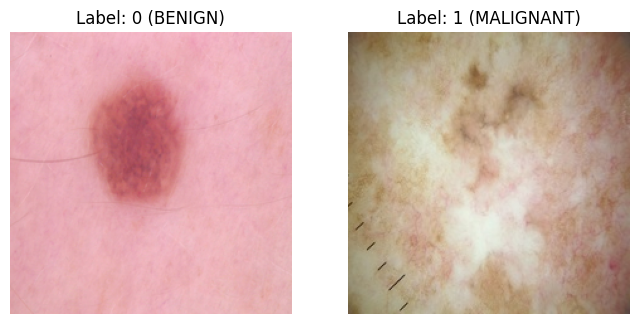

In [32]:
# 라벨이 0인 이미지와 1인 이미지 각각 하나씩 가져오기
sample_image_0 = X[y == 0][0].reshape(224, 224, 3)
sample_image_1 = X[y == 1][0].reshape(224, 224, 3)

# 샘플 이미지 시각화
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(sample_image_0)
axes[0].set_title("Label: 0 (BENIGN)")
axes[0].axis('off')

axes[1].imshow(sample_image_1)
axes[1].set_title("Label: 1 (MALIGNANT)")
axes[1].axis('off')

In [33]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y) # train, val, test data split

In [34]:
print("데이터 로딩 및 전처리 완료")
print(f"훈련 데이터 형태: {X_train.shape}, 레이블 형태: {y_train.shape}")
print(f"검증 데이터 형태: {X_val.shape}, 레이블 형태: {y_val.shape}")
print(f"테스트 데이터 형태: {X_test.shape}, 레이블 형태: {y_test.shape}")

데이터 로딩 및 전처리 완료
훈련 데이터 형태: (1600, 224, 224, 3), 레이블 형태: (1600,)
검증 데이터 형태: (200, 224, 224, 3), 레이블 형태: (200,)
테스트 데이터 형태: (200, 224, 224, 3), 레이블 형태: (200,)


#### 모델 생성

In [35]:
def create_simple_cnn(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape), # 입력층
        MaxPooling2D((2, 2)),   # Maxpooling
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        Flatten(),  # 가장 큰 특징을 모아서 1차원 배열로 변환
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')  # sigmoid는 이진 분류를 위한 활성화함수(단일클래스)
    ])
    return model

In [36]:
input_shape = (224, 224, 3)  # grayscale: 1, rgb: 3
model = create_simple_cnn(input_shape)  # 모델 생성 (input_shape에 맞게)

model.compile(optimizer='adam', # Optimizer: adam 사용
              loss='binary_crossentropy', # sigmoid를 사용했기 때문에 binary loss 사용
              metrics=['accuracy']) # 평가 metrics: accuracy

early_stopping = EarlyStopping(   # 특정 조건을 만족하면 stop을 하도록 조건을 추가
    monitor='val_loss',
    patience=10,  # 가중치 변화가 없는 지 확인하는 횟수
    verbose=1,
    mode='min',   # loss 값은 최소값으로 찾기
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(   # 가중치를 저장
    'best_simpleCNN_model.h5',
    monitor='val_accuracy',
    mode='max',   # validation 가장 큰 값
    verbose=1,
    save_best_only=True
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 flatten_1 (Flatten)         (None, 173056)           

In [37]:
history = model.fit(
    X_train, y_train, # train data
    validation_data=(X_val, y_val), # validation data
    epochs=50, # 반복 횟수
    batch_size=32,  # 배치 사이즈
    callbacks=[early_stopping, model_checkpoint, MemoryCleanupCallback()]  # 학습 stop 조건, 가중치 파일 저장
)

Epoch 1/50


2024-07-10 14:31:51.969156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.7773 - accuracy: 0.5956

2024-07-10 14:31:59.959587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.76000, saving model to best_simpleCNN_model.h5
GPU memory was cleaned!
50/50 [==============================] - 10s 167ms/step - loss: 0.7773 - accuracy: 0.5956 - val_loss: 0.5500 - val_accuracy: 0.7600
Epoch 2/50


2024-07-10 14:32:01.845261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.5157 - accuracy: 0.7538

2024-07-10 14:32:07.949757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 2: val_accuracy improved from 0.76000 to 0.79000, saving model to best_simpleCNN_model.h5
GPU memory was cleaned!
50/50 [==============================] - 7s 138ms/step - loss: 0.5157 - accuracy: 0.7538 - val_loss: 0.4581 - val_accuracy: 0.7900
Epoch 3/50


2024-07-10 14:32:09.078570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.4233 - accuracy: 0.8081

2024-07-10 14:32:15.210488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 3: val_accuracy improved from 0.79000 to 0.81500, saving model to best_simpleCNN_model.h5
GPU memory was cleaned!
50/50 [==============================] - 7s 136ms/step - loss: 0.4233 - accuracy: 0.8081 - val_loss: 0.4188 - val_accuracy: 0.8150
Epoch 4/50


2024-07-10 14:32:16.257711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.4092 - accuracy: 0.8062

2024-07-10 14:32:22.800966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 4: val_accuracy did not improve from 0.81500
GPU memory was cleaned!
50/50 [==============================] - 8s 144ms/step - loss: 0.4092 - accuracy: 0.8062 - val_loss: 0.4667 - val_accuracy: 0.8100
Epoch 5/50


2024-07-10 14:32:23.826050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.3864 - accuracy: 0.8119

2024-07-10 14:32:30.018398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 5: val_accuracy did not improve from 0.81500
GPU memory was cleaned!
50/50 [==============================] - 7s 134ms/step - loss: 0.3864 - accuracy: 0.8119 - val_loss: 0.4651 - val_accuracy: 0.7500
Epoch 6/50


2024-07-10 14:32:30.971665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.3828 - accuracy: 0.8112

2024-07-10 14:32:37.135227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 6: val_accuracy did not improve from 0.81500
GPU memory was cleaned!
50/50 [==============================] - 7s 135ms/step - loss: 0.3828 - accuracy: 0.8112 - val_loss: 0.4634 - val_accuracy: 0.7700
Epoch 7/50


2024-07-10 14:32:38.085598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.3976 - accuracy: 0.8087

2024-07-10 14:32:44.162877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 7: val_accuracy did not improve from 0.81500
GPU memory was cleaned!
50/50 [==============================] - 7s 132ms/step - loss: 0.3976 - accuracy: 0.8087 - val_loss: 0.4555 - val_accuracy: 0.7850
Epoch 8/50


2024-07-10 14:32:45.058599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.4049 - accuracy: 0.8031

2024-07-10 14:32:51.121871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 8: val_accuracy improved from 0.81500 to 0.82000, saving model to best_simpleCNN_model.h5
GPU memory was cleaned!
50/50 [==============================] - 7s 133ms/step - loss: 0.4049 - accuracy: 0.8031 - val_loss: 0.4179 - val_accuracy: 0.8200
Epoch 9/50


2024-07-10 14:32:52.086578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.3522 - accuracy: 0.8331

2024-07-10 14:32:58.146563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 9: val_accuracy did not improve from 0.82000
GPU memory was cleaned!
50/50 [==============================] - 7s 129ms/step - loss: 0.3522 - accuracy: 0.8331 - val_loss: 0.4575 - val_accuracy: 0.8200
Epoch 10/50


2024-07-10 14:32:58.950129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.3076 - accuracy: 0.8475

2024-07-10 14:33:04.929812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 10: val_accuracy did not improve from 0.82000
GPU memory was cleaned!
50/50 [==============================] - 7s 131ms/step - loss: 0.3076 - accuracy: 0.8475 - val_loss: 0.5030 - val_accuracy: 0.7850
Epoch 11/50


2024-07-10 14:33:05.830272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.3036 - accuracy: 0.8606

2024-07-10 14:33:11.793173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 11: val_accuracy did not improve from 0.82000
GPU memory was cleaned!
50/50 [==============================] - 7s 130ms/step - loss: 0.3036 - accuracy: 0.8606 - val_loss: 0.5920 - val_accuracy: 0.8000
Epoch 12/50


2024-07-10 14:33:12.686703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.2935 - accuracy: 0.8575

2024-07-10 14:33:18.779635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 12: val_accuracy did not improve from 0.82000
GPU memory was cleaned!
50/50 [==============================] - 7s 134ms/step - loss: 0.2935 - accuracy: 0.8575 - val_loss: 0.4615 - val_accuracy: 0.8150
Epoch 13/50


2024-07-10 14:33:19.728921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.3067 - accuracy: 0.8606

2024-07-10 14:33:25.730014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 13: val_accuracy did not improve from 0.82000
GPU memory was cleaned!
50/50 [==============================] - 7s 131ms/step - loss: 0.3067 - accuracy: 0.8606 - val_loss: 0.4598 - val_accuracy: 0.8150
Epoch 14/50


2024-07-10 14:33:26.594655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.2980 - accuracy: 0.8681

2024-07-10 14:33:32.815480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 14: val_accuracy did not improve from 0.82000
GPU memory was cleaned!
50/50 [==============================] - 7s 133ms/step - loss: 0.2980 - accuracy: 0.8681 - val_loss: 0.4224 - val_accuracy: 0.8150
Epoch 15/50


2024-07-10 14:33:33.698144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.2853 - accuracy: 0.8606

2024-07-10 14:33:39.949109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 15: val_accuracy improved from 0.82000 to 0.82500, saving model to best_simpleCNN_model.h5
GPU memory was cleaned!
50/50 [==============================] - 7s 137ms/step - loss: 0.2853 - accuracy: 0.8606 - val_loss: 0.4327 - val_accuracy: 0.8250
Epoch 16/50


2024-07-10 14:33:40.942682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.2665 - accuracy: 0.8719

2024-07-10 14:33:47.080496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 16: val_accuracy did not improve from 0.82500
GPU memory was cleaned!
50/50 [==============================] - 7s 134ms/step - loss: 0.2665 - accuracy: 0.8719 - val_loss: 0.5417 - val_accuracy: 0.8000
Epoch 17/50


2024-07-10 14:33:48.026456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.2702 - accuracy: 0.8706

2024-07-10 14:33:54.244515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 17: val_accuracy did not improve from 0.82500
GPU memory was cleaned!
50/50 [==============================] - 7s 132ms/step - loss: 0.2702 - accuracy: 0.8706 - val_loss: 0.4447 - val_accuracy: 0.8200
Epoch 18/50


2024-07-10 14:33:55.148912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.2703 - accuracy: 0.8769

2024-07-10 14:34:01.112061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Restoring model weights from the end of the best epoch: 8.

Epoch 18: val_accuracy did not improve from 0.82500
GPU memory was cleaned!
50/50 [==============================] - 7s 135ms/step - loss: 0.2703 - accuracy: 0.8769 - val_loss: 0.5243 - val_accuracy: 0.7600
Epoch 18: early stopping


In [38]:
model = tf.keras.models.load_model('best_simpleCNN_model.h5') # 학습 후 가장 높은 성능을 보이는 가중치를 가져오기

#### Result

In [39]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:4f}")

2024-07-10 14:34:28.034398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 1s 96ms/step - loss: 0.6318 - accuracy: 0.7950
Test Accuracy: 0.795000


In [40]:
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int).flatten() # 확률값이 0.5 초과는 1로 저장할 것

2024-07-10 14:34:37.859420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 1s 76ms/step


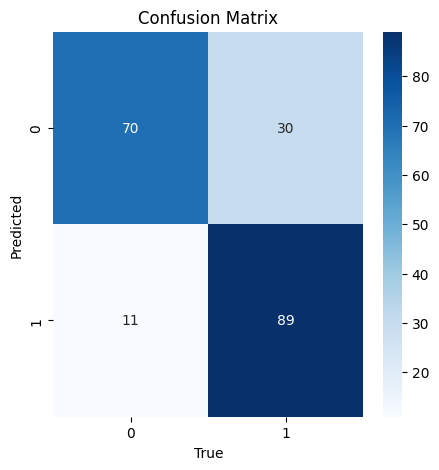

In [41]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

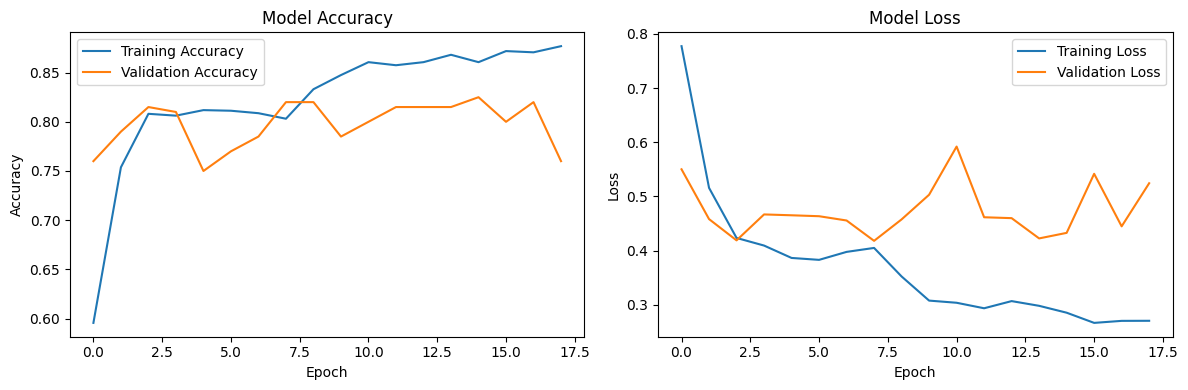

In [42]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### ResNet50V2 method

#### 환경설정

In [2]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
# [MacOS] GPU 설정 및 사용 가능 체크
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU is available")
else:
    print("GPU is not available, using CPU")

# [MacOS] 그래픽카드 메모리 정리 메소드
import gc
class MemoryCleanupCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        tf.keras.backend.clear_session()
        print("GPU memory was cleaned!")

GPU is available


#### 데이터 로드

In [4]:
def load_and_preprocess_data(base_dir, img_size=(224, 224)):
    images = []  # image data를 모으는 빈 리스트 생성
    labels = []  # image data의 label(class)를 저장할 리스트 생성
    categories = ['BENIGN', 'MALIGNANT']  # 카테고리 종류

    for category in categories:
        class_num = categories.index(category)  # benign: 0, malignant: 1
        base_path = os.path.join(base_dir, category)  # 데이터 구조:
        base_files = os.listdir(base_path)  # train폴더에서 category에 맞는 데이터 받아옴
        np.random.shuffle(base_files)  # 데이터를 랜덤하게 섞음

        for idx in range(1000):  # 각 카테고리 별 1000장씩 받아옴
            image_path = os.path.join(base_path, base_files[idx])
            image = cv2.imread(image_path)  # color로 이미지 데이터 받아오기
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # BGR에서 RGB로 변환
            image = cv2.resize(image, img_size)  # 이미지 사이즈 resize
            images.append(image)
            labels.append(class_num)

    # 이미지를 정규화
    images = np.array(images).astype('float32') / 255.0
    return images, np.array(labels)

In [5]:
def split_data(X, y, test_size=0.2, val_size=0.5):
    X_train, X_val_test, y_train, y_val_test = train_test_split(X,  # image data
                                                                y,  # label data
                                                                test_size=test_size, # X_train, y_train에 80%의 데이터 입력
                                                                stratify=y,  # normal, pneumonia 클래스의 비율을 맞춰서 분할하기 위함
                                                                random_state=42)  # 랜덤시드 설정
    X_val, X_test, y_val, y_test = train_test_split(X_val_test,
                                                    y_val_test,
                                                    test_size=val_size,  # 남은 20% 데이터를 1/2로 나눔 -> val:test = 1:1 (10% : 10%)
                                                    stratify=y_val_test,
                                                    random_state=42)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [6]:
base_dir = 'datasets/skin-cancer' # 데이터 경로
X, y = load_and_preprocess_data(base_dir) # 2000장 데이터 로드

In [7]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y) # train, val, test data split

In [8]:
print("데이터 로딩 및 전처리 완료")
print(f"훈련 데이터 형태: {X_train.shape}, 레이블 형태: {y_train.shape}")
print(f"검증 데이터 형태: {X_val.shape}, 레이블 형태: {y_val.shape}")
print(f"테스트 데이터 형태: {X_test.shape}, 레이블 형태: {y_test.shape}")

데이터 로딩 및 전처리 완료
훈련 데이터 형태: (1600, 224, 224, 3), 레이블 형태: (1600,)
검증 데이터 형태: (200, 224, 224, 3), 레이블 형태: (200,)
테스트 데이터 형태: (200, 224, 224, 3), 레이블 형태: (200,)


#### Model setting

In [9]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [10]:
def create_ResNet50V2_model(input_shape):
    base_model = ResNet50V2(weights='imagenet', 
                            include_top=False, 
                            input_shape=input_shape)
    # include_top: 전이 학습
    # True: 시작부터 완전 연결 계층까지 그대로 가져다 사용
    # False: 그대로 사용하지 않겠다는 의미
    base_model.trainable = False

    # 완전 연결 계층(inference)
    features = base_model.output
    features = GlobalAveragePooling2D()(features)
    features = Dense(1024, activation='relu')(features)
    output = Dense(1, activation='sigmoid')(features)

    model = Model(inputs=base_model.input, outputs=output)
    return model

In [15]:
# 기존 데이터 rgb 이기 때문에 3차원으로 수정할 필요x
# X_train_rgb = np.repeat(X_train, 3, axis=-1)
# X_val_rgb = np.repeat(X_val, 3, axis=-1)
# X_test_rgb = np.repeat(X_test, 3, axis=-1)

# ResNet50V2용 전처리
X_train_preprocessed = tf.keras.applications.resnet_v2.preprocess_input(X_train)
X_val_preprocessed = tf.keras.applications.resnet_v2.preprocess_input(X_val)
X_test_preprocessed = tf.keras.applications.resnet_v2.preprocess_input(X_test)

input_shape = (224,224,3)
model = create_ResNet50V2_model(input_shape)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [16]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_ResNet50V2_model.h5', save_best_only=True),
]

In [17]:
history = model.fit(
    X_train_preprocessed, y_train, # train data
    validation_data=(X_val_preprocessed, y_val), # validation data
    epochs=50, # 반복 횟수
    batch_size=32,  # 배치 사이즈
    callbacks=callbacks
)
MemoryCleanupCallback()     # gpu memory cleaner

Epoch 1/50


2024-07-10 10:50:04.095321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.7115 - accuracy: 0.5450

2024-07-10 10:50:18.170190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GPU memory was cleaned!
50/50 [==============================] - 20s 314ms/step - loss: 0.7115 - accuracy: 0.5450 - val_loss: 0.6141 - val_accuracy: 0.6900
Epoch 2/50


2024-07-10 10:50:21.968934: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.6200 - accuracy: 0.6581

2024-07-10 10:50:33.944109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GPU memory was cleaned!
50/50 [==============================] - 15s 277ms/step - loss: 0.6200 - accuracy: 0.6581 - val_loss: 0.6398 - val_accuracy: 0.5650
Epoch 3/50


2024-07-10 10:50:36.490093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.6031 - accuracy: 0.6687

2024-07-10 10:50:48.435230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GPU memory was cleaned!
50/50 [==============================] - 15s 287ms/step - loss: 0.6031 - accuracy: 0.6687 - val_loss: 0.5752 - val_accuracy: 0.7100
Epoch 4/50


2024-07-10 10:50:51.468357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.6090 - accuracy: 0.6700

2024-07-10 10:51:03.413342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GPU memory was cleaned!
50/50 [==============================] - 15s 294ms/step - loss: 0.6090 - accuracy: 0.6700 - val_loss: 0.5502 - val_accuracy: 0.7100
Epoch 5/50


2024-07-10 10:51:06.797996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.5756 - accuracy: 0.6963

2024-07-10 10:51:18.993414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GPU memory was cleaned!
50/50 [==============================] - 15s 293ms/step - loss: 0.5756 - accuracy: 0.6963 - val_loss: 0.6493 - val_accuracy: 0.5850
Epoch 6/50


2024-07-10 10:51:22.225514: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.5636 - accuracy: 0.7038

2024-07-10 10:51:34.664285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GPU memory was cleaned!
50/50 [==============================] - 16s 305ms/step - loss: 0.5636 - accuracy: 0.7038 - val_loss: 0.5328 - val_accuracy: 0.7500
Epoch 7/50


2024-07-10 10:51:38.506252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.5600 - accuracy: 0.7125

2024-07-10 10:51:50.739616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GPU memory was cleaned!
50/50 [==============================] - 16s 307ms/step - loss: 0.5600 - accuracy: 0.7125 - val_loss: 0.5305 - val_accuracy: 0.7550
Epoch 8/50


2024-07-10 10:51:54.713234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.5806 - accuracy: 0.6950

2024-07-10 10:52:07.191560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GPU memory was cleaned!
50/50 [==============================] - 16s 293ms/step - loss: 0.5806 - accuracy: 0.6950 - val_loss: 0.5501 - val_accuracy: 0.6900
Epoch 9/50


2024-07-10 10:52:10.441422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.5578 - accuracy: 0.7206

2024-07-10 10:52:23.197920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GPU memory was cleaned!
50/50 [==============================] - 17s 322ms/step - loss: 0.5578 - accuracy: 0.7206 - val_loss: 0.5511 - val_accuracy: 0.7500
Epoch 10/50


2024-07-10 10:52:27.729919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.5488 - accuracy: 0.7100

2024-07-10 10:52:40.736914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GPU memory was cleaned!
50/50 [==============================] - 17s 322ms/step - loss: 0.5488 - accuracy: 0.7100 - val_loss: 0.5207 - val_accuracy: 0.7300
Epoch 11/50


2024-07-10 10:52:45.039334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.5457 - accuracy: 0.7181

2024-07-10 10:52:57.532760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GPU memory was cleaned!
50/50 [==============================] - 16s 304ms/step - loss: 0.5457 - accuracy: 0.7181 - val_loss: 0.5269 - val_accuracy: 0.7100
Epoch 12/50


2024-07-10 10:53:01.347703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.5283 - accuracy: 0.7356

2024-07-10 10:53:14.005254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GPU memory was cleaned!
50/50 [==============================] - 18s 331ms/step - loss: 0.5283 - accuracy: 0.7356 - val_loss: 0.5183 - val_accuracy: 0.7250
Epoch 13/50


2024-07-10 10:53:19.056923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.5485 - accuracy: 0.6981

2024-07-10 10:53:31.730232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GPU memory was cleaned!
50/50 [==============================] - 17s 313ms/step - loss: 0.5485 - accuracy: 0.6981 - val_loss: 0.5229 - val_accuracy: 0.7200
Epoch 14/50


2024-07-10 10:53:35.870322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.5508 - accuracy: 0.7150

2024-07-10 10:53:48.893192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GPU memory was cleaned!
50/50 [==============================] - 18s 324ms/step - loss: 0.5508 - accuracy: 0.7150 - val_loss: 0.5975 - val_accuracy: 0.7100
Epoch 15/50


2024-07-10 10:53:53.650420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.5403 - accuracy: 0.7350

2024-07-10 10:54:06.396401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GPU memory was cleaned!
50/50 [==============================] - 18s 325ms/step - loss: 0.5403 - accuracy: 0.7350 - val_loss: 0.5340 - val_accuracy: 0.7850
Epoch 16/50


2024-07-10 10:54:11.220822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.5495 - accuracy: 0.7188

2024-07-10 10:54:24.422186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GPU memory was cleaned!
50/50 [==============================] - 18s 334ms/step - loss: 0.5495 - accuracy: 0.7188 - val_loss: 0.5181 - val_accuracy: 0.7350
Epoch 17/50


2024-07-10 10:54:29.681489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.5255 - accuracy: 0.7356

2024-07-10 10:54:43.007042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GPU memory was cleaned!
50/50 [==============================] - 18s 328ms/step - loss: 0.5255 - accuracy: 0.7356 - val_loss: 0.5206 - val_accuracy: 0.7850
Epoch 18/50


2024-07-10 10:54:47.939348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.5164 - accuracy: 0.7337

2024-07-10 10:55:01.255313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GPU memory was cleaned!
50/50 [==============================] - 19s 335ms/step - loss: 0.5164 - accuracy: 0.7337 - val_loss: 0.5094 - val_accuracy: 0.7150
Epoch 19/50


2024-07-10 10:55:06.535822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.5188 - accuracy: 0.7469

2024-07-10 10:55:19.824195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GPU memory was cleaned!
50/50 [==============================] - 18s 328ms/step - loss: 0.5188 - accuracy: 0.7469 - val_loss: 0.5172 - val_accuracy: 0.7450
Epoch 20/50


2024-07-10 10:55:24.807060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.5208 - accuracy: 0.7425

2024-07-10 10:55:38.276718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GPU memory was cleaned!
50/50 [==============================] - 18s 321ms/step - loss: 0.5208 - accuracy: 0.7425 - val_loss: 0.5082 - val_accuracy: 0.7700
Epoch 21/50


2024-07-10 10:55:42.742801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.5138 - accuracy: 0.7469

2024-07-10 10:55:55.726928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GPU memory was cleaned!
50/50 [==============================] - 18s 335ms/step - loss: 0.5138 - accuracy: 0.7469 - val_loss: 0.5041 - val_accuracy: 0.7550
Epoch 22/50


2024-07-10 10:56:01.015659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.5146 - accuracy: 0.7375

2024-07-10 10:56:14.287955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GPU memory was cleaned!
50/50 [==============================] - 18s 324ms/step - loss: 0.5146 - accuracy: 0.7375 - val_loss: 0.5156 - val_accuracy: 0.8000
Epoch 23/50


2024-07-10 10:56:18.955493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.5310 - accuracy: 0.7444

2024-07-10 10:56:32.383399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GPU memory was cleaned!
50/50 [==============================] - 18s 329ms/step - loss: 0.5310 - accuracy: 0.7444 - val_loss: 0.5426 - val_accuracy: 0.7650
Epoch 24/50


2024-07-10 10:56:37.302206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.5131 - accuracy: 0.7494

2024-07-10 10:56:50.514779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GPU memory was cleaned!
50/50 [==============================] - 18s 331ms/step - loss: 0.5131 - accuracy: 0.7494 - val_loss: 0.5084 - val_accuracy: 0.7900
Epoch 25/50


2024-07-10 10:56:55.560852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.5209 - accuracy: 0.7269

2024-07-10 10:57:09.955362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GPU memory was cleaned!
50/50 [==============================] - 20s 348ms/step - loss: 0.5209 - accuracy: 0.7269 - val_loss: 0.5048 - val_accuracy: 0.7200
Epoch 26/50


2024-07-10 10:57:15.690718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.5186 - accuracy: 0.7356

2024-07-10 10:57:30.064434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GPU memory was cleaned!
50/50 [==============================] - 22s 375ms/step - loss: 0.5186 - accuracy: 0.7356 - val_loss: 0.5641 - val_accuracy: 0.6950
Epoch 27/50


2024-07-10 10:57:37.259577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.4996 - accuracy: 0.7569

2024-07-10 10:57:51.536594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GPU memory was cleaned!
50/50 [==============================] - 22s 390ms/step - loss: 0.4996 - accuracy: 0.7569 - val_loss: 0.5005 - val_accuracy: 0.7850
Epoch 28/50


2024-07-10 10:57:59.222194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.4965 - accuracy: 0.7738

2024-07-10 10:58:14.492134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GPU memory was cleaned!
50/50 [==============================] - 23s 393ms/step - loss: 0.4965 - accuracy: 0.7738 - val_loss: 0.5050 - val_accuracy: 0.7200
Epoch 29/50


2024-07-10 10:58:22.164703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.5468 - accuracy: 0.7344

2024-07-10 10:58:37.021494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GPU memory was cleaned!
50/50 [==============================] - 20s 333ms/step - loss: 0.5468 - accuracy: 0.7344 - val_loss: 0.5173 - val_accuracy: 0.7300
Epoch 30/50


2024-07-10 10:58:42.099678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.4927 - accuracy: 0.7538

2024-07-10 10:58:57.212333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GPU memory was cleaned!
50/50 [==============================] - 20s 335ms/step - loss: 0.4927 - accuracy: 0.7538 - val_loss: 0.5041 - val_accuracy: 0.7950
Epoch 31/50


2024-07-10 10:59:02.119460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.4852 - accuracy: 0.7575

2024-07-10 10:59:16.945815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GPU memory was cleaned!
50/50 [==============================] - 23s 394ms/step - loss: 0.4852 - accuracy: 0.7575 - val_loss: 0.5008 - val_accuracy: 0.8000
Epoch 32/50


2024-07-10 10:59:24.753085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.5258 - accuracy: 0.7294

2024-07-10 10:59:40.447905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GPU memory was cleaned!
50/50 [==============================] - 23s 391ms/step - loss: 0.5258 - accuracy: 0.7294 - val_loss: 0.5036 - val_accuracy: 0.7900
Epoch 33/50


2024-07-10 10:59:47.483673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.4935 - accuracy: 0.7525

2024-07-10 11:00:02.330167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GPU memory was cleaned!
50/50 [==============================] - 23s 401ms/step - loss: 0.4935 - accuracy: 0.7525 - val_loss: 0.4948 - val_accuracy: 0.7400
Epoch 34/50


2024-07-10 11:00:10.450150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.5561 - accuracy: 0.7231

2024-07-10 11:00:25.486543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GPU memory was cleaned!
50/50 [==============================] - 24s 412ms/step - loss: 0.5561 - accuracy: 0.7231 - val_loss: 0.6223 - val_accuracy: 0.6800
Epoch 35/50


2024-07-10 11:00:34.215409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.5003 - accuracy: 0.7437

2024-07-10 11:00:49.539647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GPU memory was cleaned!
50/50 [==============================] - 22s 380ms/step - loss: 0.5003 - accuracy: 0.7437 - val_loss: 0.4912 - val_accuracy: 0.7550
Epoch 36/50


2024-07-10 11:00:56.275084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.5103 - accuracy: 0.7450

2024-07-10 11:01:11.531477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GPU memory was cleaned!
50/50 [==============================] - 23s 390ms/step - loss: 0.5103 - accuracy: 0.7450 - val_loss: 0.5213 - val_accuracy: 0.7100
Epoch 37/50


2024-07-10 11:01:19.178725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.5116 - accuracy: 0.7469

2024-07-10 11:01:34.120669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GPU memory was cleaned!
50/50 [==============================] - 23s 389ms/step - loss: 0.5116 - accuracy: 0.7469 - val_loss: 0.4931 - val_accuracy: 0.7400
Epoch 38/50


2024-07-10 11:01:41.776970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.4888 - accuracy: 0.7519

2024-07-10 11:01:56.857788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GPU memory was cleaned!
50/50 [==============================] - 23s 397ms/step - loss: 0.4888 - accuracy: 0.7519 - val_loss: 0.4957 - val_accuracy: 0.8050
Epoch 39/50


2024-07-10 11:02:04.694834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.5052 - accuracy: 0.7544

2024-07-10 11:02:19.832628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GPU memory was cleaned!
50/50 [==============================] - 23s 400ms/step - loss: 0.5052 - accuracy: 0.7544 - val_loss: 0.4915 - val_accuracy: 0.7950
Epoch 40/50


2024-07-10 11:02:27.812710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.4756 - accuracy: 0.7688

2024-07-10 11:02:43.245202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GPU memory was cleaned!
50/50 [==============================] - 23s 398ms/step - loss: 0.4756 - accuracy: 0.7688 - val_loss: 0.4972 - val_accuracy: 0.8000
Epoch 41/50


2024-07-10 11:02:51.240777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.4713 - accuracy: 0.7775

2024-07-10 11:03:06.414816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GPU memory was cleaned!
50/50 [==============================] - 23s 391ms/step - loss: 0.4713 - accuracy: 0.7775 - val_loss: 0.5018 - val_accuracy: 0.7950
Epoch 42/50


2024-07-10 11:03:14.170899: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.4630 - accuracy: 0.7781

2024-07-10 11:03:29.320501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GPU memory was cleaned!
50/50 [==============================] - 23s 392ms/step - loss: 0.4630 - accuracy: 0.7781 - val_loss: 0.4913 - val_accuracy: 0.7450
Epoch 43/50


2024-07-10 11:03:37.069291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.4664 - accuracy: 0.7656

2024-07-10 11:03:52.219690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GPU memory was cleaned!
50/50 [==============================] - 24s 407ms/step - loss: 0.4664 - accuracy: 0.7656 - val_loss: 0.4842 - val_accuracy: 0.7450
Epoch 44/50


2024-07-10 11:04:00.698483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.4625 - accuracy: 0.7763

2024-07-10 11:04:16.048600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GPU memory was cleaned!
50/50 [==============================] - 23s 392ms/step - loss: 0.4625 - accuracy: 0.7763 - val_loss: 0.4905 - val_accuracy: 0.7300
Epoch 45/50


2024-07-10 11:04:23.648322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.4747 - accuracy: 0.7731

2024-07-10 11:04:38.667482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GPU memory was cleaned!
50/50 [==============================] - 23s 396ms/step - loss: 0.4747 - accuracy: 0.7731 - val_loss: 0.7945 - val_accuracy: 0.5750
Epoch 46/50


2024-07-10 11:04:46.657779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.5077 - accuracy: 0.7381

2024-07-10 11:05:01.993117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GPU memory was cleaned!
50/50 [==============================] - 23s 398ms/step - loss: 0.5077 - accuracy: 0.7381 - val_loss: 0.4996 - val_accuracy: 0.7200
Epoch 47/50


2024-07-10 11:05:09.806171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.4836 - accuracy: 0.7575

2024-07-10 11:05:25.241527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GPU memory was cleaned!
50/50 [==============================] - 23s 399ms/step - loss: 0.4836 - accuracy: 0.7575 - val_loss: 0.5332 - val_accuracy: 0.7050
Epoch 48/50


2024-07-10 11:05:32.922672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.4630 - accuracy: 0.7781

2024-07-10 11:05:48.226814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GPU memory was cleaned!
50/50 [==============================] - 24s 411ms/step - loss: 0.4630 - accuracy: 0.7781 - val_loss: 0.4821 - val_accuracy: 0.7550
Epoch 49/50


2024-07-10 11:05:56.715653: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.4811 - accuracy: 0.7600

2024-07-10 11:06:12.183467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GPU memory was cleaned!
50/50 [==============================] - 25s 439ms/step - loss: 0.4811 - accuracy: 0.7600 - val_loss: 0.4783 - val_accuracy: 0.7750
Epoch 50/50


2024-07-10 11:06:21.876529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.4688 - accuracy: 0.7837

2024-07-10 11:06:37.386330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GPU memory was cleaned!
50/50 [==============================] - 23s 396ms/step - loss: 0.4688 - accuracy: 0.7837 - val_loss: 0.5667 - val_accuracy: 0.7000


In [19]:
model = tf.keras.models.load_model('models/skin-cancer/best_ResNet50V2_model.h5')

#### Result

In [20]:
test_loss, test_acc = model.evaluate(X_test_preprocessed, y_test)
print(f"Test accuracy: {test_acc:.4f}")

2024-07-10 11:12:44.352059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 8s 708ms/step - loss: 0.4303 - accuracy: 0.7650
Test accuracy: 0.7650


2024-07-10 11:12:59.926573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 7s 592ms/step


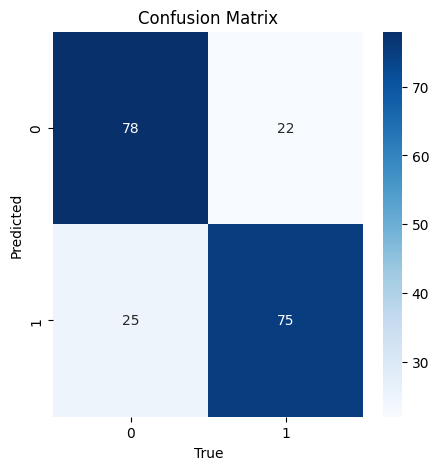

In [21]:
y_pred = model.predict(X_test_preprocessed)
y_pred_classes = (y_pred>0.5).astype(int)

# confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

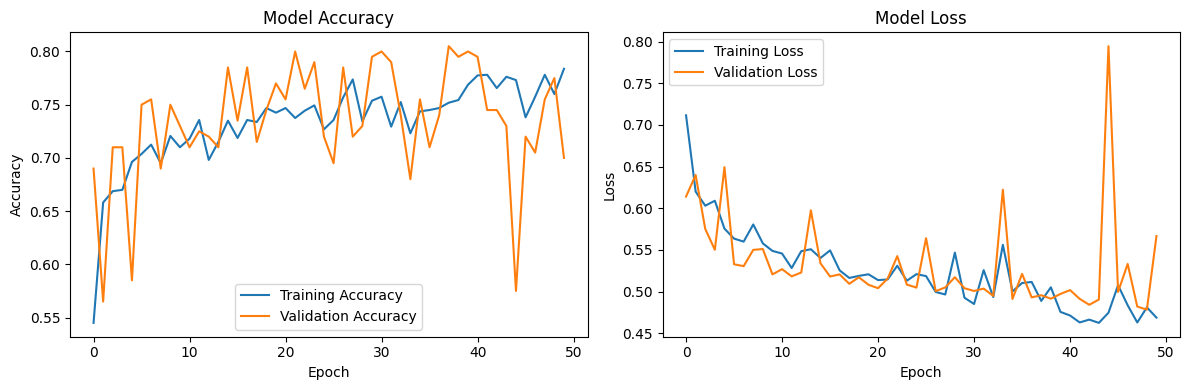

In [25]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()